<ipython-input-10-13fb2ffa795e>:41: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, x = scipy.io.wavfile.read(cAudioFilePath)


errCentRms_fftmax:  (1944.2066196318924, 7.718390804597701, 0.06778309409888357)
errCentRms_hps:  (383.0734768006775, 7.103448275862069, 0.15311004784688995)


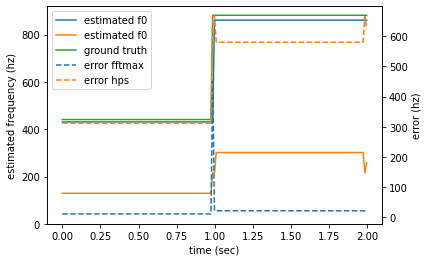

In [10]:
from typing import Tuple
import numpy as np
import scipy.io.wavfile
from matplotlib import pyplot as plt
import os.path
from glob import glob
from scipy.io.wavfile import read as wavread
import math


T = np.ndarray  # for autocomplete engine, will be deleted before submission
# BLOCK_SIZE = 1 << 10  # SHOULD NOT BE USED IN FUNCTION DEFINIION
# HOP_SIZE = BLOCK_SIZE >> 2
DB_TRUNCATION_THRESHOLD = -100


# proudly plagiarized myself, again, by simply copying from assg 1.
def block_audio(x, blockSize, hopSize, fs) -> Tuple[T, T]:
    """plain implementation of spliting input signal into blocks of frames."""

    # equivalent to num_of_blocks = ceil(x / hopSize)
    num_of_blocks = len(x) // hopSize
    if len(x) % hopSize:
        num_of_blocks += 1
    x = np.pad(x, (0, (num_of_blocks - 1) * hopSize + blockSize - len(x)))

    xb = np.zeros((num_of_blocks, blockSize))
    time_in_sec = np.zeros((num_of_blocks,))

    for i in range(num_of_blocks):
        # i-th block
        l = i * hopSize
        time_in_sec[i] = l / fs
        xb[i] = x[l : l + blockSize]

    return xb, time_in_sec


# plagiarized from alex
def tool_read_audio(cAudioFilePath):
    samplerate, x = scipy.io.wavfile.read(cAudioFilePath)

    if x.dtype == "float32":
        audio = x
    else:
        # change range to [-1,1)
        nbits = {
            np.dtype("uint8"): 8,
            np.dtype("int16"): 16,
            np.dtype("int32"): 32,
        }[x.dtype]

        audio = x / (1 << (nbits - 1))

    # special case of unsigned format
    if x.dtype == "uint8":
        audio = audio - 1.0

    return (samplerate, audio)


def fft_block(xb):
    """Helper function that fft (one) block of audio.

    Args:
        xb (T): blocked signal, with shape (..., BLOCK_SIZE)

    Returns:
        T: corresponding magnitude response of `xb`
    """
    # hann window
    # - https://en.wikipedia.org/wiki/Hann_function
    # - $w[n] = \sin^2\frac{\pi n}{N}$
    w = np.sin(np.pi * np.arange(xb.shape[-1]) / xb.shape[-1]) ** 2

    # lets hope it will boardcast from (BLOCK_SIZE,) to (..., BLOCK_SIZE)
    windowed_xb = xb * w

    # fft, magnitude response
    X_b = np.abs(np.fft.rfft(windowed_xb))  # (..., (BLOCK_SIZE >> 1) + 1)

    return X_b


def amplitude_to_db(xb):
    """Convert amplitude into dB scale. Truncated at -100dB."""
    return np.maximum(20 * np.log10(xb), DB_TRUNCATION_THRESHOLD)


def magnitude_to_db(X_b):
    # see https://dsp.stackexchange.com/questions/47173/theoretical-maximum-of-dft
    # for the reason why divide by `BLOCK_SIZE` here.
    return amplitude_to_db(X_b / BLOCK_SIZE)


# --- A.1 ---
def compute_spectrogram(xb: T, fs: int):
    # xb.shape = (num_of_blocks, block_size)
    block_size = xb.shape[-1]
    Xb = fft_block(xb)  # shape: (num_of_blocks, (block_size >> 1) + 1)
    f_in_hz = np.fft.rfftfreq(
        block_size, d=1 / fs
    )  # shape: ((block_size >> 1) + 1, )
    return Xb, f_in_hz


# --- A.2 ---
def track_pitch_fftmax(x: T, blockSize: int, hopSize: int, fs: int):
    xb, time_in_sec = block_audio(x, blockSize, hopSize, fs)
    Xb, f_in_hz = compute_spectrogram(xb, fs)
    f0 = f_in_hz[np.argmax(Xb, axis=-1)]
    return f0, time_in_sec  # both have shape (num_of_block, )


# --- B.1 ---
def get_f0_from_Hps(X, fs, order):
    hps = X.copy()
    f_in_hz = np.fft.rfftfreq((X.shape[-1] - 1) << 1, d=1/fs)
    for i in range(1, order):
        Xd = X[:, ::i + 1]
        hps = hps[:, :Xd.shape[1]]
        hps *= Xd ** 2
    f0 = f_in_hz[np.argmax(hps, axis=-1)]  # F in chat
    return f0


# --- B.2 ---
def track_pitch_hps(x, blockSize, hopSize, fs):
    xb, time_in_sec = block_audio(
        x, blockSize=blockSize, hopSize=hopSize, fs=fs
    )
    Xb, f_in_hz = compute_spectrogram(xb, fs=fs)
    f0 = get_f0_from_Hps(Xb, fs, order=4)
    return f0, time_in_sec


# --- C.1 ---
def extract_rms(xb):
    rms = np.maximum(
        20 * np.log10(np.sqrt(np.mean(xb ** 2, axis=-1))),
        DB_TRUNCATION_THRESHOLD,
    )
    return rms


# --- C.2 ---
def create_voicing_mask(rmsDb, thresholdDb):
    return 0 + rmsDb >= thresholdDb


# --- C.3 ---
def apply_voicing_mask(f0, mask):
    f0Adj = f0 * mask
    return f0Adj


# --- D.1 ---
def eval_voiced_fp(estimation, annotation):
    # false positive: Actually negative, predicted positive
    return np.sum(estimation != 0) / np.sum(annotation == 0)


# --- D.2 ---
def eval_voiced_fn(estimation, annotation):
    # false negative
    return np.sum(estimation == 0) / np.sum(annotation != 0)


# --- D.3 ---
def eval_pitchtrack_v2(estimation, annotation):
    # return RMS of cent
    err_cent_rms = 0
    for a, b in zip(estimation, annotation):
        if a and b:
            err_cent_rms += (1200 * np.log2(a / b)) ** 2
    err_cent_rms = (err_cent_rms / len(estimation)) ** 0.5
    pfp = eval_voiced_fp(estimation, annotation)
    pfn = eval_voiced_fn(estimation, annotation)
    return err_cent_rms, pfp, pfn


# --- E.1 ---
def executeassign3():
    BLOCK_SIZE = 1024
    HOP_SIZE = 512
    def gen_sin(f, t, fs):
        return np.sin(2 * np.pi * f * np.arange(t * fs) / fs)
    fs = 44100
    sin_ = np.concatenate((gen_sin(441, 1, fs), gen_sin(882, 1, fs)))
    ref_ = np.concatenate(
        (np.ones(shape=(fs,)) * 441, np.ones(shape=(fs,)) * 882)
    )
    ref_in_block = np.max(
        block_audio(ref_, BLOCK_SIZE, HOP_SIZE, fs)[0], axis=1
    )

    f0_fftmax, time_in_sec = track_pitch_fftmax(sin_, BLOCK_SIZE, HOP_SIZE, fs)
    f0_hps, _ = track_pitch_hps(sin_, BLOCK_SIZE, HOP_SIZE, fs)
    # plot
    fig, ax = plt.subplots()
    ax.plot(time_in_sec, f0_fftmax, label="estimated f0")
    ax.plot(time_in_sec, f0_hps, label="estimated f0")
    ax.plot(time_in_sec, ref_in_block, label="ground truth")
    ax.set_ylim(0)
    ax.set_xlabel("time (sec)")
    ax.set_ylabel("estimated frequency (hz)")
    ax2 = ax.twinx()
    ax2.plot(time_in_sec, ref_in_block - f0_fftmax, "--", label="error fftmax")
    ax2.plot(time_in_sec, ref_in_block - f0_hps, "--", label="error hps")
    ax2.set_ylabel("error (hz)")
    a, b = ax.get_legend_handles_labels()
    c, d = ax2.get_legend_handles_labels()
    ax.legend(a + c, b + d, loc=2)
    plt.savefig("sig_error.png")
    
# --- E.3 ---

# rename run_evaluation function in the end
def run_evaluation_fftmax(complete_path_to_data_folder):
    wavpath = np.array([])
    txtpath = np.array([])
    for full_filepath in os.listdir(complete_path_to_data_folder):
        if full_filepath.endswith('.wav'):
            wav_path = np.append(wavpath, complete_path_to_data_folder + full_filepath)
            txt_path = np.append(txtpath, complete_path_to_data_folder + full_filepath.split('.')[0] + '.f0.Corrected.txt')
    
    blockSize = 1024 
    hopSize = 512
    
    all_estimates = np.array([])
    all_groundtruths = np.array([])
    for wavfile, txtfile in zip(wav_path, txt_path):
        fs, x = tool_read_audio(wavfile)
        file = np.loadtxt(txtfile)
        groundtruths = file[:, 2]

        estimates, timestamps = track_pitch_fftmax(x, blockSize, hopSize, fs)
        all_estimates = np.append(all_estimates, estimates)
        all_groundtruths = np.append(all_groundtruths, groundtruths)

    errCentRms = eval_pitchtrack_v2(all_estimates, all_groundtruths)
    return errCentRms 

def run_evaluation_hps(complete_path_to_data_folder):
    wavpath = np.array([])
    txtpath = np.array([])
    for full_filepath in os.listdir(complete_path_to_data_folder):
        if full_filepath.endswith('.wav'):
            wav_path = np.append(wavpath, complete_path_to_data_folder + full_filepath)
            txt_path = np.append(txtpath, complete_path_to_data_folder + full_filepath.split('.')[0] + '.f0.Corrected.txt')
    
    blockSize = 1024 
    hopSize = 512
    
    all_estimates = np.array([])
    all_groundtruths = np.array([])
    for wavfile, txtfile in zip(wav_path, txt_path):
        fs, x = tool_read_audio(wavfile)
        file = np.loadtxt(txtfile)
        groundtruths = file[:, 2]

        estimates, timestamps = track_pitch_hps(x, blockSize, hopSize, fs)
        all_estimates = np.append(all_estimates, estimates)
        all_groundtruths = np.append(all_groundtruths, groundtruths)

    errCentRms = eval_pitchtrack_v2(all_estimates, all_groundtruths)
    return errCentRms 

# --- E.5 ---
def track_pitch_acf(x, iBlockLength, iHopLength, f_s):

    # initialize
    f_max = 2000
    fMinThresh = .35
    iNumOfBlocks = math.ceil(x.size / iHopLength)

    # compute time stamps
    t = (np.arange(0, iNumOfBlocks) * iHopLength + (iBlockLength / 2)) / f_s

    # allocate memory
    f = np.zeros(iNumOfBlocks)

    for n in range(0, iNumOfBlocks):
        eta_min = int(round(f_s / f_max)) - 1

        i_start = n * iHopLength
        i_stop = np.min([x.size - 1, i_start + iBlockLength - 1])

        # calculate the acf
        if not x[np.arange(i_start, i_stop + 1)].sum():
            continue
        else:
            x_tmp = x[np.arange(i_start, i_stop + 1)]
            afCorr = np.correlate(x_tmp, x_tmp, "full") / np.dot(x_tmp, x_tmp)

        afCorr = afCorr[np.arange(iBlockLength, afCorr.size)]

        # update eta_min to avoid main lobe
        eta_tmp = np.argmax(afCorr < fMinThresh)
        eta_min = np.max([eta_min, eta_tmp])

        afDeltaCorr = np.diff(afCorr)
        eta_tmp = np.argmax(afDeltaCorr > 0)
        eta_min = np.max([eta_min, eta_tmp])

        # find the coefficients specified in eta
        f[n] = np.argmax(afCorr[np.arange(eta_min + 1, afCorr.size)]) + 1

        # convert to Hz
        f[n] = f_s / (f[n] + eta_min + 1)

    return (f, t)


def track_pitch(x, blockSize, hopSize, fs, method, voicingThres): 
    if method == 'acf':
        f0, _ = track_pitch_acf(x, blockSize, hopSize, fs)
    elif method == 'max':
        f0, _ = track_pitch_fftmax(x, blockSize, hopSize, fs)
    elif method == 'hps':
        f0, _ = track_pitch_hps(x, blockSize, hopSize, fs)
    else:
        print("Choose either 'acf', 'max' or 'hps' method")
    
    xb, timeInSec = block_audio(x, blockSize, hopSize, fs)
    rmsDb = extract_rms(xb)
    mask = create_voicing_mask(rmsDb, voicingThres)
    f0Adj = apply_voicing_mask(f0, mask)
    return f0Adj, timeInSec


if __name__ == "__main__":
    executeassign3()
    
    complete_path_to_data_folder = "trainData/"
    
    # run_evaluation function will be renamed during submission
    
    # Evaluate fftmax over test set
    errCentRms_fftmax = run_evaluation_fftmax(complete_path_to_data_folder)
    
    # Evaluate hps over the test set
    errCentRms_hps = run_evaluation_hps(complete_path_to_data_folder)
    
    print("errCentRms_fftmax: ", errCentRms_fftmax)
    print("errCentRms_hps: ", errCentRms_hps)
    
    
    
    
    
    # for full_filename in glob("./trainData/*.wav"):
    #     filepath, filename_ext = os.path.split(full_filename)

    #     fs, x = tool_read_audio(full_filename)
    #     xb, time_in_sec = block_audio(x, BLOCK_SIZE, HOP_SIZE, fs)
    #     Xb, f_in_hz = compute_spectrogram(xb, fs)
    #     f0_fftmax, _ = track_pitch_fftmax(x, BLOCK_SIZE, HOP_SIZE, fs)
    #     f0_hps, _ = track_pitch_hps(x, BLOCK_SIZE, HOP_SIZE, fs)
    #     rms = extract_rms(xb)
    #     voicing_mask = create_voicing_mask(rms, -30)
    #     plt.plot(time_in_sec, rms)
    #     plt.plot(time_in_sec, voicing_mask)
    #     plt.show()
    #     plt.clf()
    #     print(Xb.shape, f0_fftmax.shape, f0_hps.shape)

    #     plt.figure(figsize=(36, 6))
    #     # plt.subplot(2, 1, 1)
    #     plt.imshow(
    #         magnitude_to_db(Xb.T),
    #         cmap="inferno",
    #         origin="lower",
    #         extent=[0, time_in_sec[-1], 0, fs / 2],
    #     )
    #     plt.plot(time_in_sec, f0_fftmax, label="estimated f0 (fft max)")
    #     plt.plot(time_in_sec, f0_hps, label="estimated f0 (hps)")
    #     plt.ylim(bottom=10)
    #     plt.yscale("log")
    #     plt.ylabel("Magnitude Response [Hz]")
    #     plt.xlabel("Time [s]")
    #     plt.legend(loc="upper left")
    #     plt.colorbar(format="%+2.0f dB", pad=0.01)
    #     plt.title("block size = %d, hop size = %d" % (BLOCK_SIZE, HOP_SIZE))
    #     plt.show()


In [11]:

# --- E.6 --- 
def track_pitch(x, blockSize, hopSize, fs, method, voicingThres):
    func = {
        'acf' : track_pitch_acf, 
        'max' : track_pitch_fftmax, 
        'hps' : track_pitch_hps
    }
    f0, _ = func[method](x, blockSize, hopSize, fs)
    
    xb, timeInSec = block_audio(x, blockSize, hopSize, fs)
    rmsDb = extract_rms(xb)
    mask = create_voicing_mask(rmsDb, voicingThres)
    f0Adj = apply_voicing_mask(f0, mask)
    return f0Adj, timeInSec

In [12]:
fs, x = tool_read_audio("trainData/01-D_AMairena.wav")
f0Adj, timeInSec = track_pitch(x, 1024, 512, fs, 'acf', -40)
plt.plot(f0Adj)

<ipython-input-10-13fb2ffa795e>:41: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, x = scipy.io.wavfile.read(cAudioFilePath)


ValueError: attempt to get argmax of an empty sequence